# Scapping Tweets based on Hashtags

In [ ]:
import requests
import pandas as pd

twitter_data = []

payload = {
    'api_key': 'ffaadf51b639cc07f2f7eb30d8144554',
    'query': 'DictatorHasina ',
    'num': '100'
}

response = requests.get('https://api.scraperapi.com/structured/twitter/search', params=payload)
data = response.json()

for result in data.get('organic_results', []):
    link = result.get('link', '')
    username = result.get('title', '').split('@')[1].split()[0] if '@' in result.get('title', '') else 'Unknown'
    text = result.get('snippet', '')

    twitter_data.append({
        'Link': link,
        'Username': username,
        'Text': text
    })

df = pd.DataFrame(twitter_data)
df.to_csv('#DictatorHasina.csv', index=False)

print("Data saved to csv.")


Data saved to csv.


In [ ]:
pip install transformers pandas torch

In [ ]:
import pandas as pd
df = pd.read_csv('TwitterBD_Protest.csv')
print(f"Initial dataset size: {df.shape[0]} tweets")


Initial dataset size: 591 tweets


# Loading GPT2 Model

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

model.eval()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# Generating Tweets

In [ ]:
import torch

def generate_tweet(prompt, max_length=100):
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(inputs, max_length=max_length, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

augmented_tweets = []

# Generate new tweets based on existing tweets
for i, row in df.iterrows():
    tweet_text = row['Text']
    generated_tweet = generate_tweet(tweet_text[:50], max_length=100)  # Generate text based on first 50 characters
    augmented_tweets.append(generated_tweet)

    if len(augmented_tweets) + df.shape[0] >= 2500:
        break


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask

# Saving all tweets in a Data Frame and saving it in a CSV

In [ ]:
augmented_df = pd.DataFrame({'Link': ['Generated' for _ in augmented_tweets], 'Text': augmented_tweets})

combined_df = pd.concat([df, augmented_df], ignore_index=True)

print(f"Augmented dataset size: {combined_df.shape[0]} tweets")

combined_df.to_csv('Augmented_TwitterBD_Protest.csv', index=False)

Augmented dataset size: 1182 tweets


# EDA

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
import string

df = pd.read_csv('Augmented_TwitterBD_Protest.csv')

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

df['Tokens'] = df['Cleaned_Text'].apply(tokenize_and_remove_stopwords)

# 1. Distribution of Tweet Lengths (Histogram)

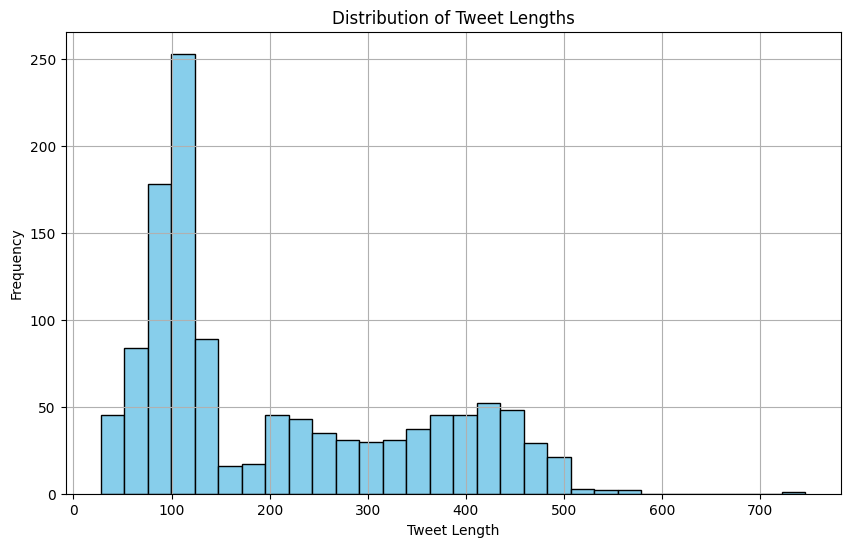

In [ ]:
df['Tweet_Length'] = df['Cleaned_Text'].apply(len)

plt.figure(figsize=(10,6))
plt.hist(df['Tweet_Length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Word Cloud


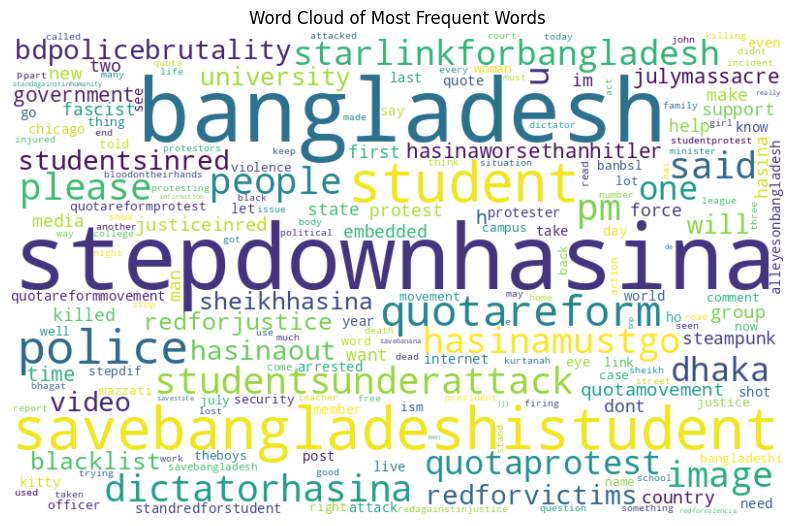

In [ ]:
all_words = ' '.join([text for text in df['Cleaned_Text']])
wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False, background_color="white").generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

# 3. Most Common Words (Bar Chart)


<ipython-input-11-fe227ab9166c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


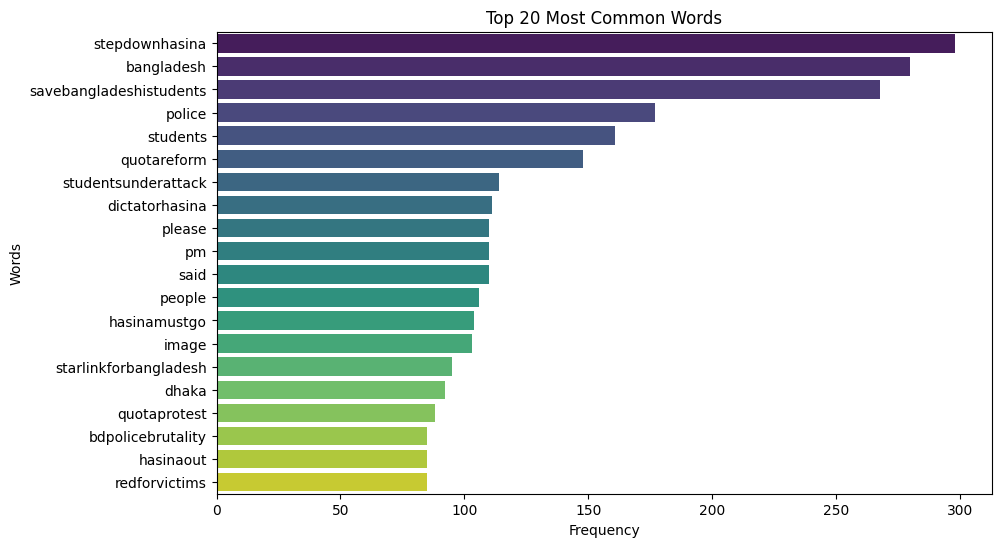

In [ ]:
all_tokens = [token for sublist in df['Tokens'] for token in sublist]
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)

words = [word for word, count in most_common_words]
counts = [count for word, count in most_common_words]

plt.figure(figsize=(10,6))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# 4. Hashtag Analysis (Bar Chart)


<ipython-input-12-6263c3ba8fa5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=hashtags, palette="magma")


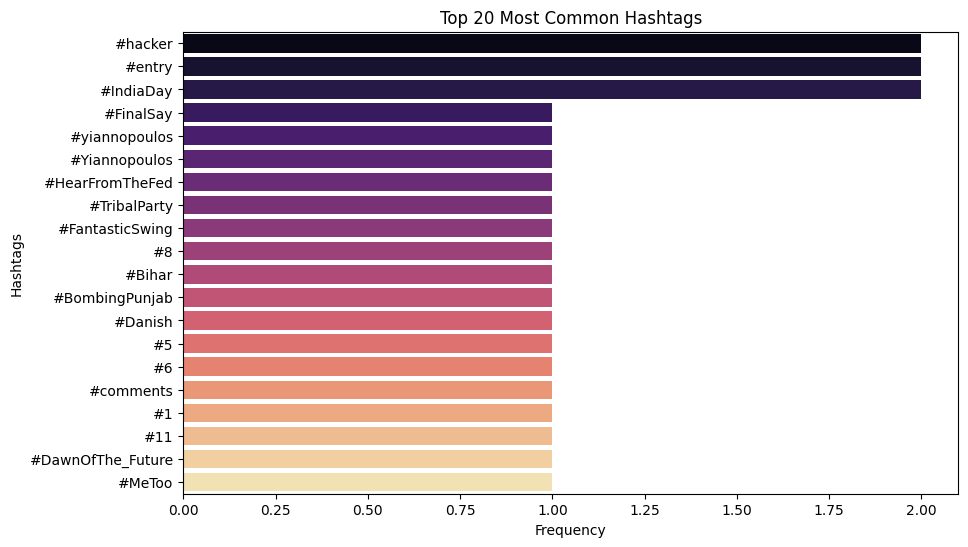

In [ ]:
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df['Hashtags'] = df['Text'].apply(extract_hashtags)
all_hashtags = [hashtag for sublist in df['Hashtags'] for hashtag in sublist]
hashtag_freq = Counter(all_hashtags)
most_common_hashtags = hashtag_freq.most_common(20)

hashtags = [hashtag for hashtag, count in most_common_hashtags]
counts = [count for hashtag, count in most_common_hashtags]

plt.figure(figsize=(10,6))
sns.barplot(x=counts, y=hashtags, palette="magma")
plt.title('Top 20 Most Common Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.show()


# 5. N-grams Analysis (Bar Chart)


<ipython-input-16-9ddcbdf6669e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=bigrams, palette="coolwarm")


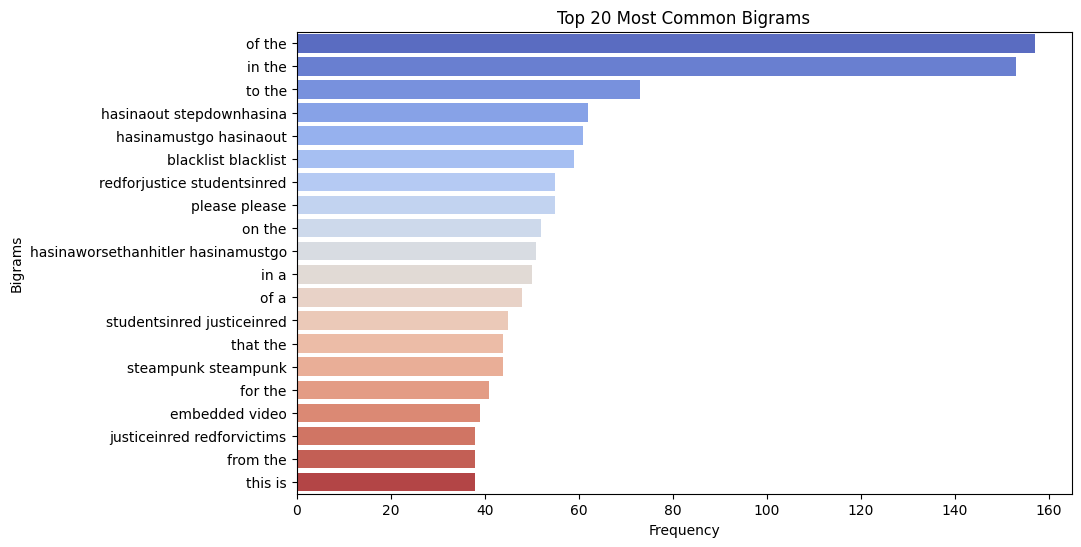

In [ ]:
def get_ngrams(text, n=2):
    tokens = text.split()
    return list(ngrams(tokens, n))

df['Bigrams'] = df['Cleaned_Text'].apply(lambda x: get_ngrams(x, 2))

all_bigrams = [bigram for sublist in df['Bigrams'] for bigram in sublist]
bigram_freq = Counter(all_bigrams)
most_common_bigrams = bigram_freq.most_common(20)

bigrams = [' '.join(bigram) for bigram, count in most_common_bigrams]
counts = [count for bigram, count in most_common_bigrams]

plt.figure(figsize=(10,6))
sns.barplot(x=counts, y=bigrams, palette="coolwarm")
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

#DistilBERT-based Sentiment Models




In [ ]:
pip install transformers torch pandas


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Sentiment Distribution:
Sentiment
NEGATIVE    1064
POSITIVE     118
Name: count, dtype: int64


<ipython-input-18-bb7cac125410>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")


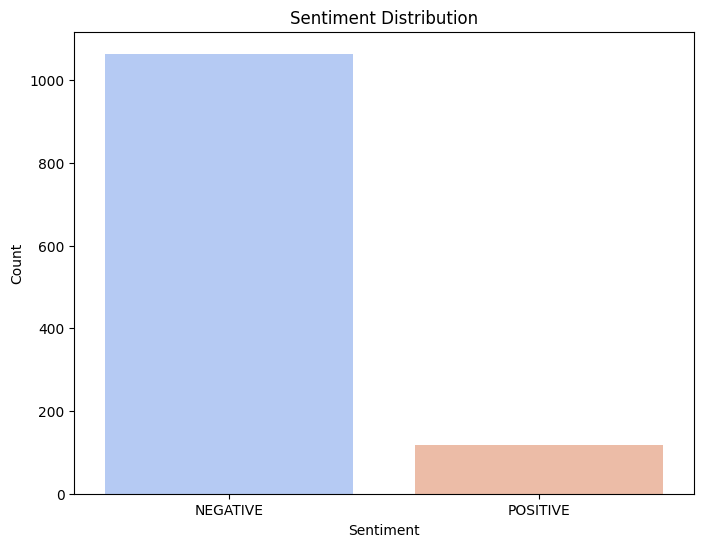

In [ ]:
import pandas as pd
import torch
from transformers import pipeline, DistilBertTokenizer, DistilBertForSequenceClassification

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

sentiment_analysis = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

df = pd.read_csv('Augmented_TwitterBD_Protest.csv')

df['Sentiment'] = df['Text'].apply(lambda tweet: sentiment_analysis(tweet)[0]['label'])

sentiment_counts = df['Sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

df.to_csv('TwitterBD_Protest_Sentiment_Analysis.csv', index=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [ ]:
def get_sentiment_with_score(tweet):
    result = sentiment_analysis(tweet)[0]
    return result['label'], result['score']

df[['Sentiment', 'Confidence']] = df['Text'].apply(lambda tweet: pd.Series(get_sentiment_with_score(tweet)))

threshold = 0.85
df_filtered = df[df['Confidence'] > threshold]

df_filtered.to_csv('Filtered_TwitterBD_Protest_Sentiment_Analysis.csv', index=False)


#EDA on the new file

In [ ]:
pip install pandas matplotlib seaborn


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('TwitterBD_Protest_Sentiment_Analysis.csv')
print(df.head())


                                                Link  \
0  https://twitter.com/RTD_BD/status/172597921898...   
1  https://twitter.com/RTD_BD/status/171644195768...   
2  https://twitter.com/basherkella/status/1816887...   
3  https://twitter.com/bdbnp78/status/17288872542...   
4  https://twitter.com/BNPBdMediaCell/status/1722...   

                                                Text Sentiment  
0  dictatorhasina spurned offers dialogue comprom...  NEGATIVE  
1  dictatorhasina pushed people beyond endurance ...  NEGATIVE  
2  dictatorhasinas forces killed two students one...  NEGATIVE  
3  bangladesh dictatorhasina orders field dummy c...  NEGATIVE  
4  bangladesh dictatorhasina suppressing freedom ...  NEGATIVE  


# Plot a pie chart for sentiment proportions


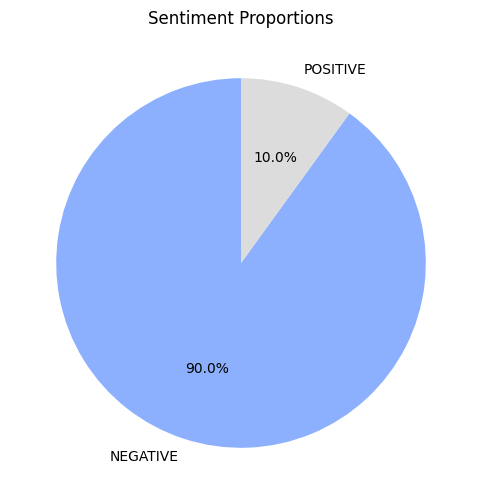

In [ ]:
plt.figure(figsize=(8, 6))
df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', 3))
plt.title('Sentiment Proportions')
plt.ylabel('')
plt.show()


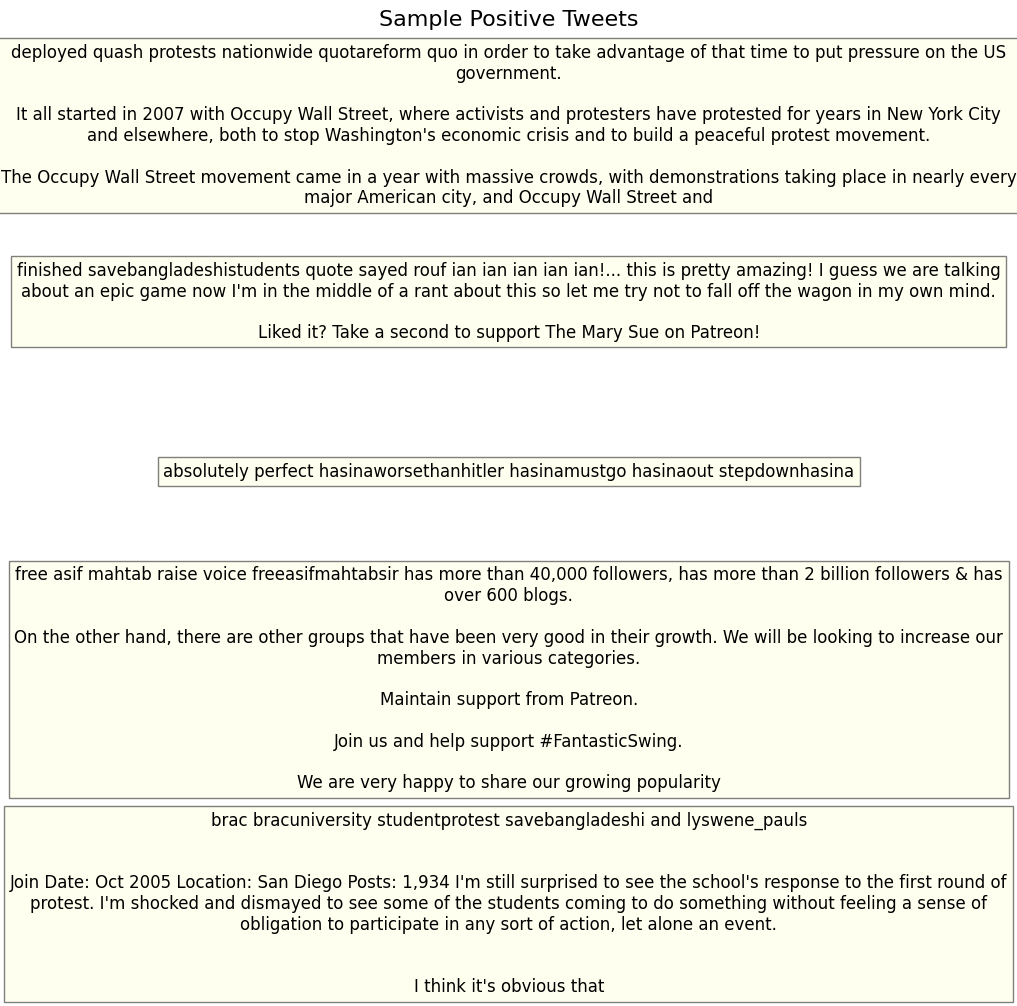

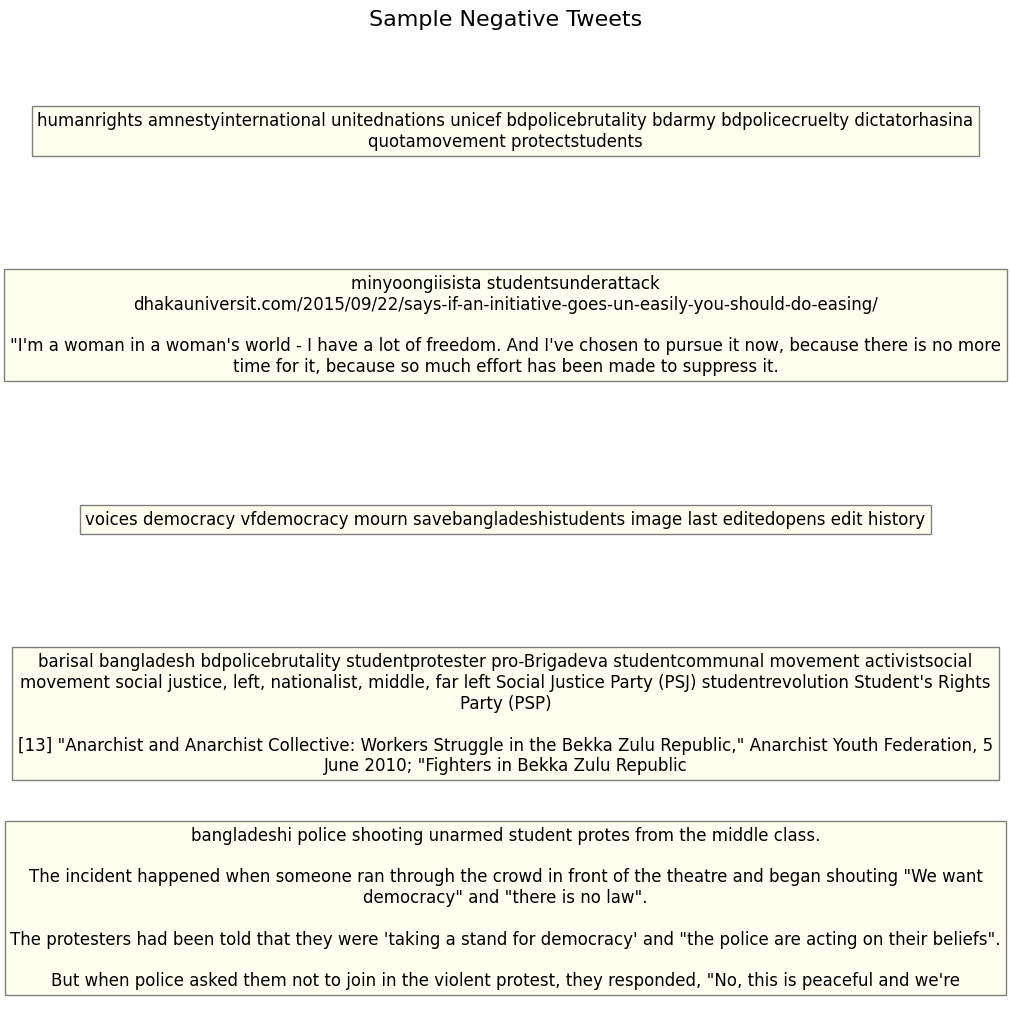

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('TwitterBD_Protest_Sentiment_Analysis.csv')

def show_sample_tweets_in_figure(df, sentiment, num_samples=5):
    sample_tweets = df[df['Sentiment'] == sentiment]['Text'].sample(n=num_samples, random_state=42).values

    fig, axs = plt.subplots(num_samples, 1, figsize=(10, num_samples * 2), constrained_layout=True)
    fig.suptitle(f"Sample {sentiment.capitalize()} Tweets", fontsize=16)

    for i, tweet in enumerate(sample_tweets):
        axs[i].text(0.5, 0.5, tweet, ha='center', va='center', wrap=True, fontsize=12, bbox=dict(facecolor='lightyellow', alpha=0.5))
        axs[i].axis('off')

    plt.show()

show_sample_tweets_in_figure(df, sentiment='POSITIVE', num_samples=5)

show_sample_tweets_in_figure(df, sentiment='NEGATIVE', num_samples=5)


In [ ]:
import pandas as pd

df = pd.read_csv('TwitterBD_Protest_Sentiment_Analysis.csv')

def display_sample_tweets(df, sentiment, num_samples=5):
    sample_tweets = df[df['Sentiment'] == sentiment]['Text'].sample(n=num_samples, random_state=42)

    sample_df = pd.DataFrame(sample_tweets)
    sample_df.columns = [f"Sample {sentiment.capitalize()} Tweets"]

    print(f"\n--- Sample {sentiment.capitalize()} Tweets ---")
    display(sample_df)

display_sample_tweets(df, sentiment='POSITIVE', num_samples=5)

display_sample_tweets(df, sentiment='NEGATIVE', num_samples=5)



--- Sample Positive Tweets ---


Sample Positive Tweets
832  deployed quash protests nationwide quotareform...
987  finished savebangladeshistudents quote sayed r...
89   absolutely perfect hasinaworsethanhitler hasin...
723  free asif mahtab raise voice freeasifmahtabsir...
622  brac bracuniversity studentprotest savebanglad...


--- Sample Negative Tweets ---


Sample Negative Tweets
33    humanrights amnestyinternational unitednations...
1168  minyoongiisista studentsunderattack dhakaunive...
425   voices democracy vfdemocracy mourn savebanglad...
801   barisal bangladesh bdpolicebrutality studentpr...
861   bangladeshi police shooting unarmed student pr...

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Sample Negative Tweets').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Gathering Tweets from India related to the protest

In [ ]:
import requests
import pandas as pd

twitter_data = []

payload = {
    'api_key': 'ffaadf51b639cc07f2f7eb30d8144554',
    'query': 'InSolidaritywithBangladesh ',
    'num': '100'
}

response = requests.get('https://api.scraperapi.com/structured/twitter/search', params=payload)
data = response.json()

for result in data.get('organic_results', []):
    link = result.get('link', '')
    username = result.get('title', '').split('@')[1].split()[0] if '@' in result.get('title', '') else 'Unknown'
    text = result.get('snippet', '')

    twitter_data.append({
        'Link': link,
        'Username': username,
        'Text': text
    })

df = pd.DataFrame(twitter_data)
df.to_csv('#InSolidaritywithBangladesh.csv', index=False)

print("Data saved to csv.")


Data saved to csv.


In [ ]:
pip install transformers torch


Emotion Analysis using Text

In [ ]:
import pandas as pd
from transformers import pipeline

emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

df = pd.read_csv('TwitterBD_Protest_Sentiment_Analysis.csv')

def get_dominant_emotion(text):
    predictions = emotion_model(text)

    emotion_scores = {p['label']: p['score'] for p in predictions[0]}
    dominant_emotion = max(emotion_scores, key=emotion_scores.get)

    return dominant_emotion

df['Emotion'] = df['Text'].apply(get_dominant_emotion)

df.to_csv('TwitterBD_Protest_Emotion_Analysis.csv', index=False)

print(df.head())


                                                Link  \
0  https://twitter.com/RTD_BD/status/172597921898...   
1  https://twitter.com/RTD_BD/status/171644195768...   
2  https://twitter.com/basherkella/status/1816887...   
3  https://twitter.com/bdbnp78/status/17288872542...   
4  https://twitter.com/BNPBdMediaCell/status/1722...   

                                                Text Sentiment   Emotion  
0  dictatorhasina spurned offers dialogue comprom...  NEGATIVE   sadness  
1  dictatorhasina pushed people beyond endurance ...  NEGATIVE  surprise  
2  dictatorhasinas forces killed two students one...  NEGATIVE     anger  
3  bangladesh dictatorhasina orders field dummy c...  NEGATIVE   neutral  
4  bangladesh dictatorhasina suppressing freedom ...  NEGATIVE     anger  


Emotion Analysis Visualization

<ipython-input-5-3ef823ffd7ed>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


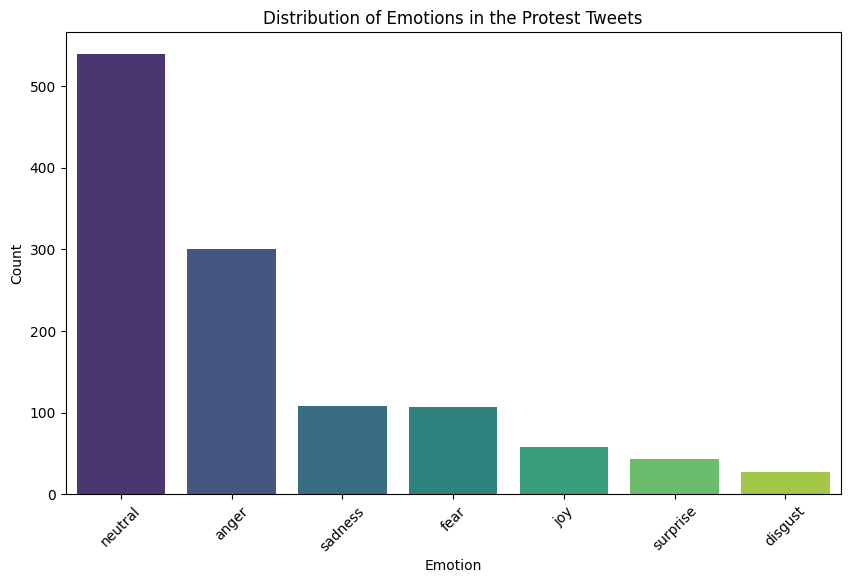

In [ ]:
emotion_counts = df['Emotion'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Distribution of Emotions in the Protest Tweets')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


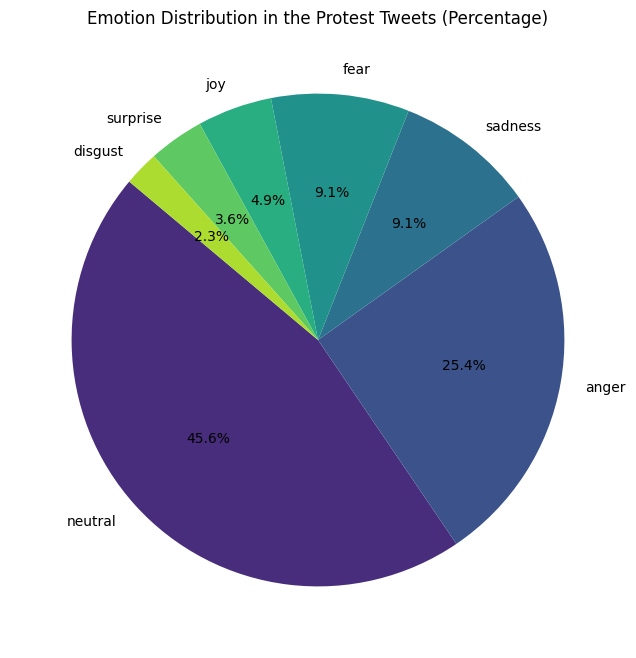

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(emotion_counts)))
plt.title('Emotion Distribution in the Protest Tweets (Percentage)')
plt.show()


<ipython-input-7-7db19e7e3f25>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Emotion', y='Tweet_Length', data=df, palette='viridis')


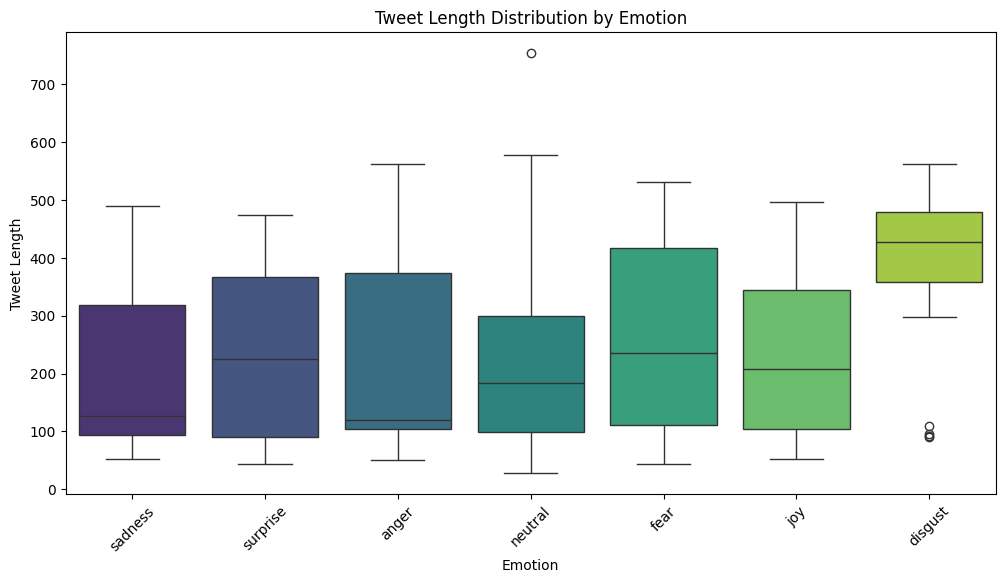

In [ ]:
df['Tweet_Length'] = df['Text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Emotion', y='Tweet_Length', data=df, palette='viridis')
plt.title('Tweet Length Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Tweet Length')
plt.xticks(rotation=45)
plt.show()


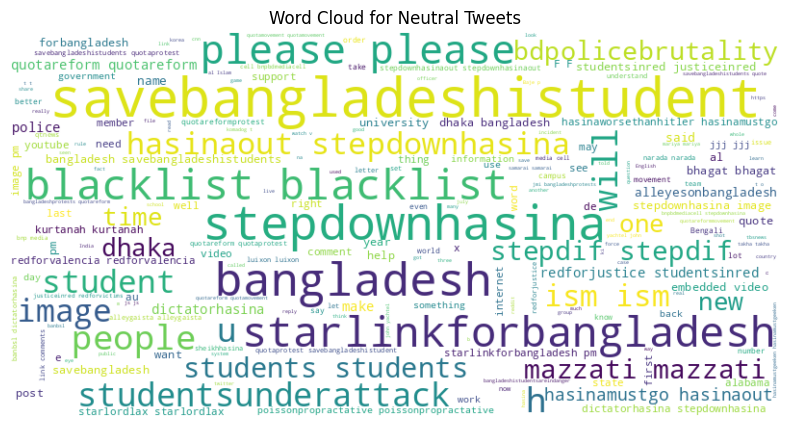

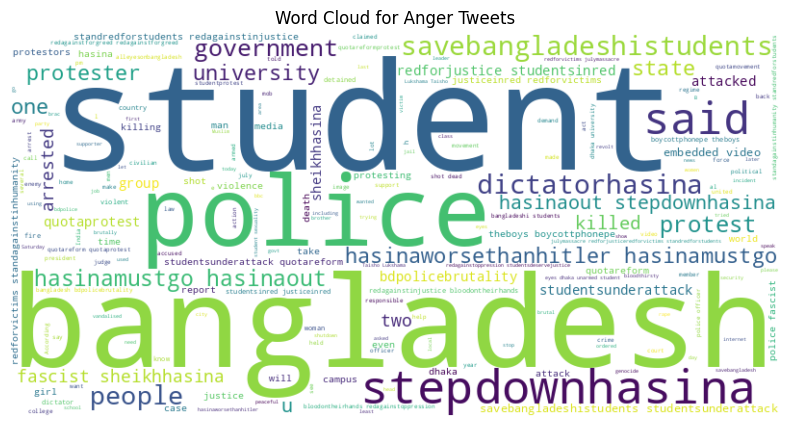

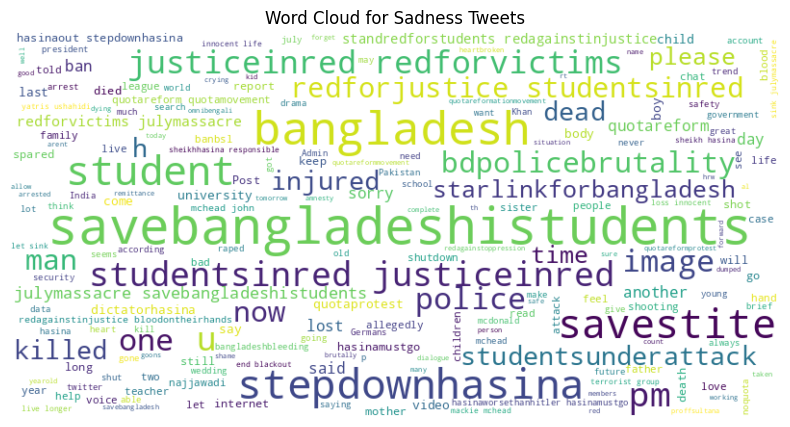

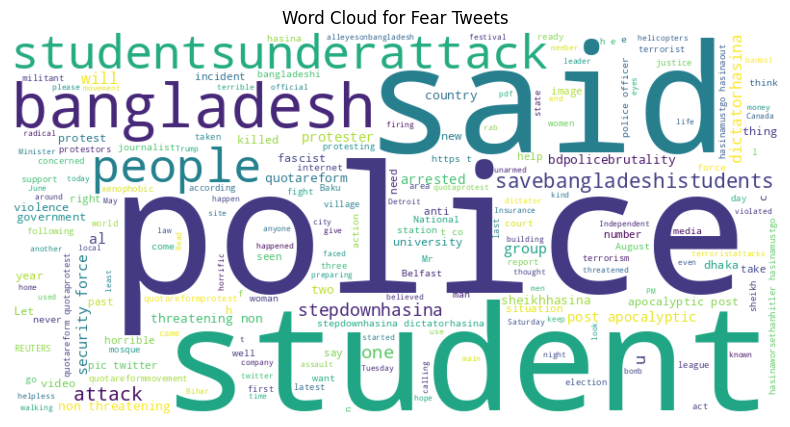

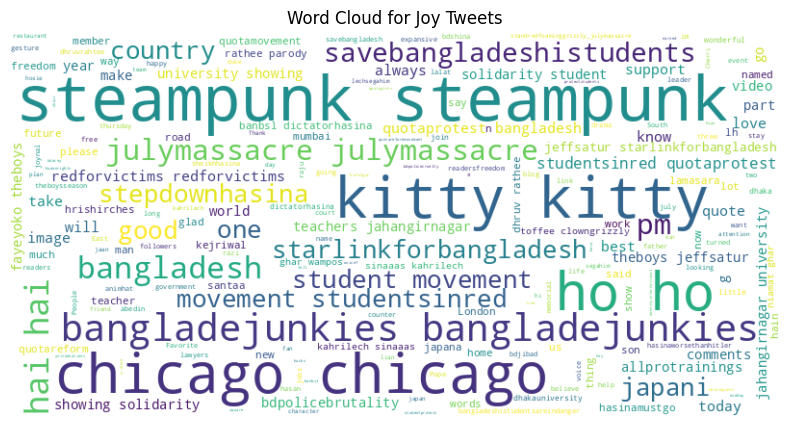

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud_for_emotion(emotion):
    text = ' '.join(df[df['Emotion'] == emotion]['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {emotion.capitalize()} Tweets')
    plt.axis('off')
    plt.show()

for emotion in emotion_counts.index[:5]:
    plot_wordcloud_for_emotion(emotion)


Scapping Tweets based on Hashtags after the Protest

In [ ]:
import requests
import pandas as pd

twitter_data = []

payload = {
    'api_key': 'ffaadf51b639cc07f2f7eb30d8144554',
    'query': 'INDvBAN',
    'num': '100'
}

response = requests.get('https://api.scraperapi.com/structured/twitter/search', params=payload)
data = response.json()

for result in data.get('organic_results', []):
    link = result.get('link', '')
    username = result.get('title', '').split('@')[1].split()[0] if '@' in result.get('title', '') else 'Unknown'
    text = result.get('snippet', '')

    twitter_data.append({
        'Link': link,
        'Username': username,
        'Text': text
    })

df = pd.DataFrame(twitter_data)
df.to_csv('#INDvBAN.csv', index=False)

print("Data saved to csv.")


Data saved to csv.


Generating more Tweets (After Protest)

In [ ]:
pip install transformers pandas torch


In [ ]:
import pandas as pd
df = pd.read_csv('Phase2.csv')
print(f"Initial dataset size: {df.shape[0]} tweets")


Initial dataset size: 1303 tweets


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

model.eval()

def generate_tweet(prompt, max_new_tokens=50):
    inputs = tokenizer.encode(prompt, return_tensors='pt')

    outputs = model.generate(
        inputs,
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

augmented_tweets = []

for i, row in df.iterrows():
    tweet_text = row['Text']

    if isinstance(tweet_text, str):
        generated_tweet = generate_tweet(tweet_text[:50], max_new_tokens=50)
        augmented_tweets.append(generated_tweet)
    else:
        print(f"Skipping row {i} due to non-string value in 'Text' column")

    if len(augmented_tweets) + df.shape[0] >= 2500:
        break

augmented_df = pd.DataFrame({
    'Link': ['Generated' for _ in augmented_tweets],
    'Text': augmented_tweets
})

combined_df = pd.concat([df, augmented_df], ignore_index=True)

print(f"Augmented dataset size: {combined_df.shape[0]} tweets")

combined_df.to_csv('Augmented_Phase2.csv', index=False)

print("Combined dataset saved to 'Augmented_Phase2.csv'")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior.

Skipping row 427 due to non-string value in 'Text' column


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Skipping row 1157 due to non-string value in 'Text' column


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Augmented dataset size: 2500 tweets
Combined dataset saved to 'Augmented_Phase2.csv'


Data Cleaning

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords

df = pd.read_csv('Augmented_Phase2.csv')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        words_list = text.split()
        cleaned_words = [word for word in words_list if word not in stop_words]
        return ' '.join(cleaned_words)
    else:
        return ""

df['Cleaned_Text'] = df['Text'].apply(clean_text)

cleaned_df = df[['Link', 'Cleaned_Text']]

cleaned_df.to_csv('Processed_Augmented_Phase2.csv', index=False)


Distribution of Tweet Lengths (After Protest)

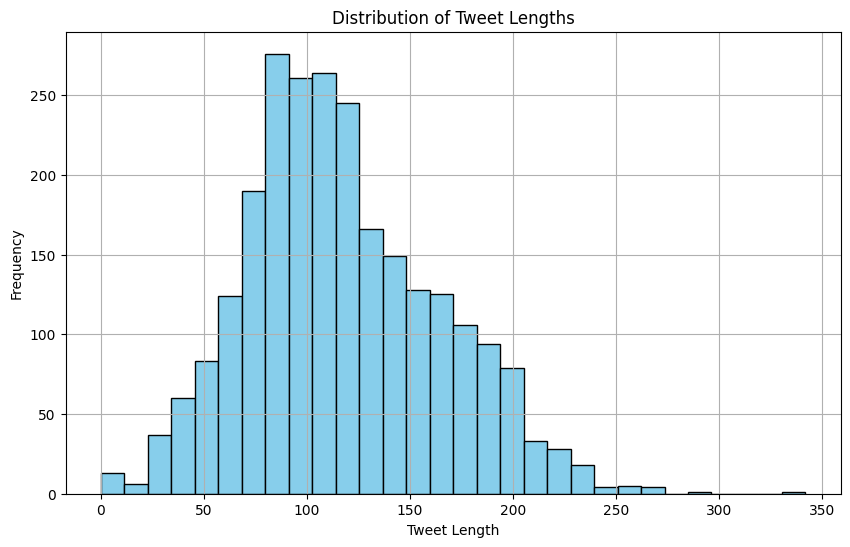

In [ ]:
df['Tweet_Length'] = df['Cleaned_Text'].apply(len)

plt.figure(figsize=(10,6))
plt.hist(df['Tweet_Length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Word Cloud (After Protest)

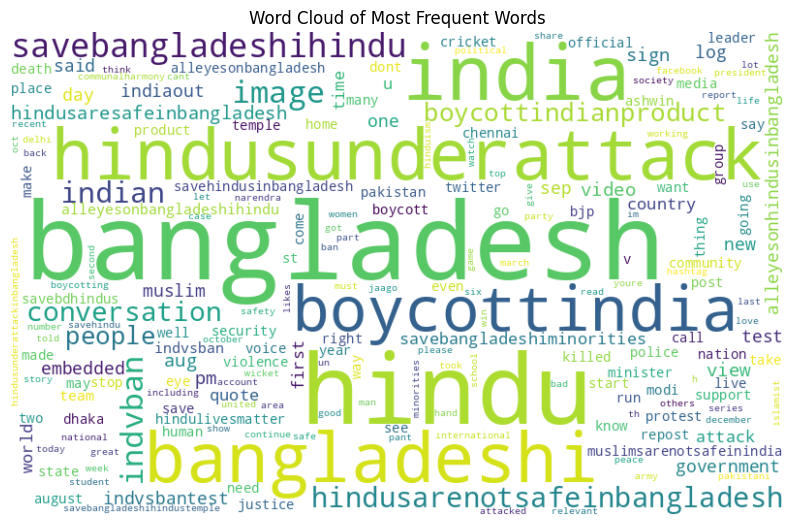

In [ ]:
all_words = ' '.join([text for text in df['Cleaned_Text']])
wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False, background_color="white").generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

N-Grams (After Protest)

<ipython-input-47-9ddcbdf6669e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=bigrams, palette="coolwarm")


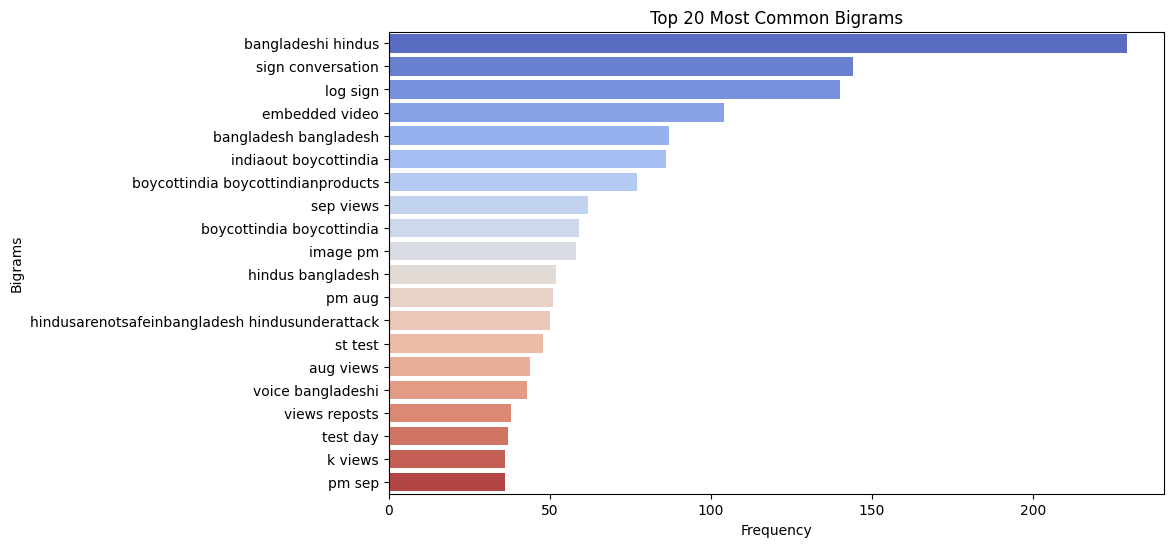

In [ ]:
def get_ngrams(text, n=2):
    tokens = text.split()
    return list(ngrams(tokens, n))

df['Bigrams'] = df['Cleaned_Text'].apply(lambda x: get_ngrams(x, 2))

all_bigrams = [bigram for sublist in df['Bigrams'] for bigram in sublist]
bigram_freq = Counter(all_bigrams)
most_common_bigrams = bigram_freq.most_common(20)

bigrams = [' '.join(bigram) for bigram, count in most_common_bigrams]
counts = [count for bigram, count in most_common_bigrams]

plt.figure(figsize=(10,6))
sns.barplot(x=counts, y=bigrams, palette="coolwarm")
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

DistilBERT-based Sentiment Models

In [ ]:
pip install transformers torch pandas


In [ ]:
df = pd.read_csv('Processed_Augmented_Phase2.csv')
print(df.columns)


Index(['Link', 'Cleaned_Text'], dtype='object')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sentiment Distribution:
Sentiment
NEGATIVE    2041
POSITIVE     447
Neutral       12
Name: count, dtype: int64


<ipython-input-53-4b05511a6c16>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")


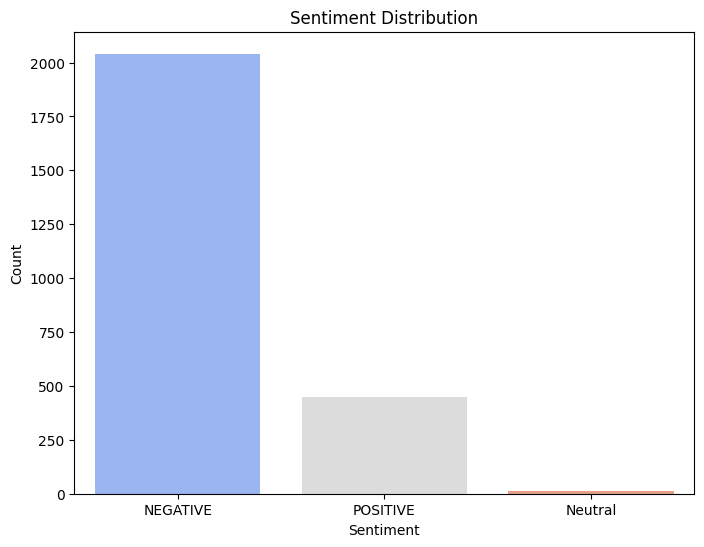

In [ ]:
import pandas as pd
import torch
from transformers import pipeline, DistilBertTokenizer, DistilBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

sentiment_analysis = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

df = pd.read_csv('Processed_Augmented_Phase2.csv')

df['Sentiment'] = df['Cleaned_Text'].apply(lambda tweet: sentiment_analysis(tweet)[0]['label'] if isinstance(tweet, str) and tweet.strip() else 'Neutral')

sentiment_counts = df['Sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

df.to_csv('Phase2_Sentiment_Analysis.csv', index=False)

plt.figure(figsize=(8,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


EDA on Sentiment Analysis (After Protest)

In [ ]:
pip install pandas matplotlib seaborn


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Phase2_Sentiment_Analysis.csv')
print(df.head())


                                                Link  \
0  https://twitter.com/sukanyaiyer2/status/182143...   
1  https://twitter.com/shashidhar147/status/18230...   
2  https://twitter.com/ThePujaTeli/status/1821053...   
3  https://twitter.com/KunalNamdeo/status/1824281...   
4  https://twitter.com/GAnurag11/status/182085261...   

                                        Cleaned_Text Sentiment  
0  gurukuldrsukanyasubbannaiyer alleyesonhindusin...  NEGATIVE  
1  savebangladeshihindus savehumanity savehumanri...  NEGATIVE  
2  wasnt places like would know atrocities happen...  NEGATIVE  
3  aug log sign conversation kunal namdeo alleyes...  NEGATIVE  
4  hindu minorities targeted bangladesh alleyeson...  NEGATIVE  


Pie Chart (After Protest)

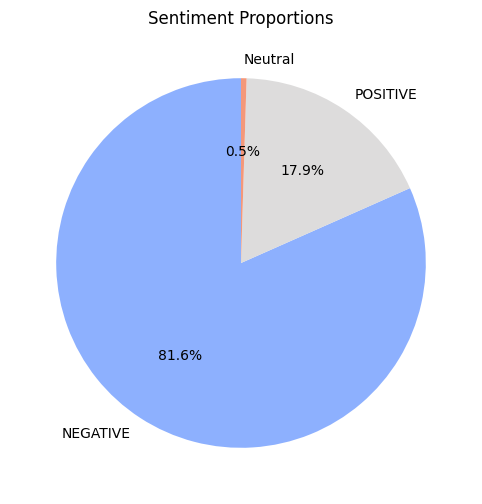

In [ ]:
plt.figure(figsize=(8, 6))
df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', 3))
plt.title('Sentiment Proportions')
plt.ylabel('')
plt.show()


In [ ]:
pip install transformers torch


Emotion Analysis (After Protest)

In [ ]:
import pandas as pd
from transformers import pipeline

emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

df = pd.read_csv('Phase2_Sentiment_Analysis.csv')

def get_dominant_emotion(text):
    if isinstance(text, str) and text.strip():
        predictions = emotion_model(text)
        emotion_scores = {p['label']: p['score'] for p in predictions[0]}
        dominant_emotion = max(emotion_scores, key=emotion_scores.get)
        return dominant_emotion
    else:
        return 'Unknown'

df['Emotion'] = df['Cleaned_Text'].apply(get_dominant_emotion)

df.to_csv('Phase2_Emotion_Analysis.csv', index=False)

print(df.head())


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


                                                Link  \
0  https://twitter.com/sukanyaiyer2/status/182143...   
1  https://twitter.com/shashidhar147/status/18230...   
2  https://twitter.com/ThePujaTeli/status/1821053...   
3  https://twitter.com/KunalNamdeo/status/1824281...   
4  https://twitter.com/GAnurag11/status/182085261...   

                                        Cleaned_Text Sentiment  Emotion  
0  gurukuldrsukanyasubbannaiyer alleyesonhindusin...  NEGATIVE  neutral  
1  savebangladeshihindus savehumanity savehumanri...  NEGATIVE  neutral  
2  wasnt places like would know atrocities happen...  NEGATIVE  sadness  
3  aug log sign conversation kunal namdeo alleyes...  NEGATIVE  neutral  
4  hindu minorities targeted bangladesh alleyeson...  NEGATIVE    anger  


EA Visualiszation (After Protest)

<ipython-input-63-8887cd22f1a0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


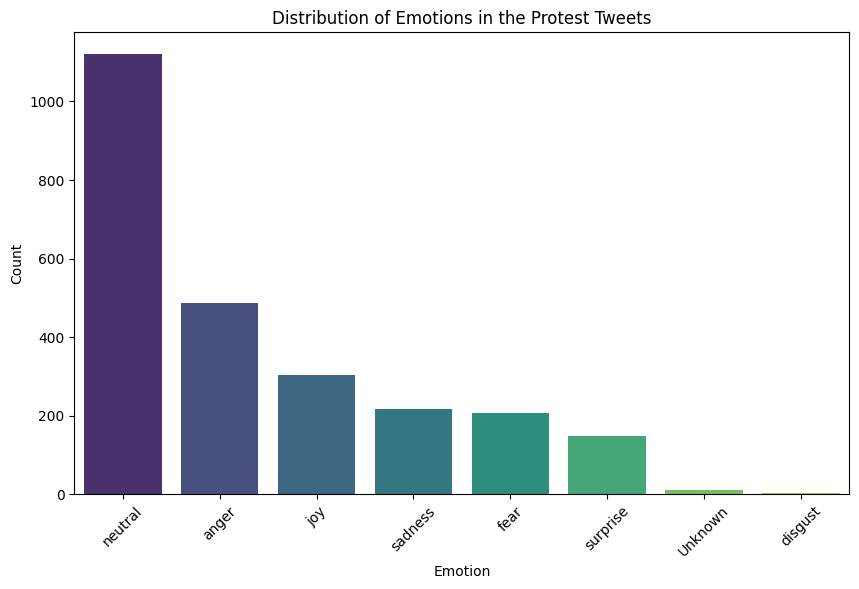

In [ ]:
emotion_counts = df['Emotion'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Distribution of Emotions in the Protest Tweets')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


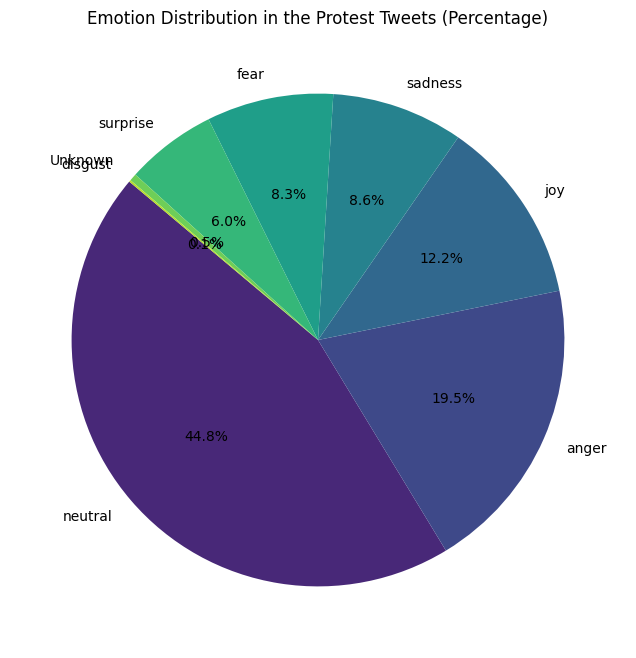

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(emotion_counts)))
plt.title('Emotion Distribution in the Protest Tweets (Percentage)')
plt.show()


<ipython-input-67-a01cc7851612>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Emotion', y='Tweet_Length', data=df, palette='viridis')


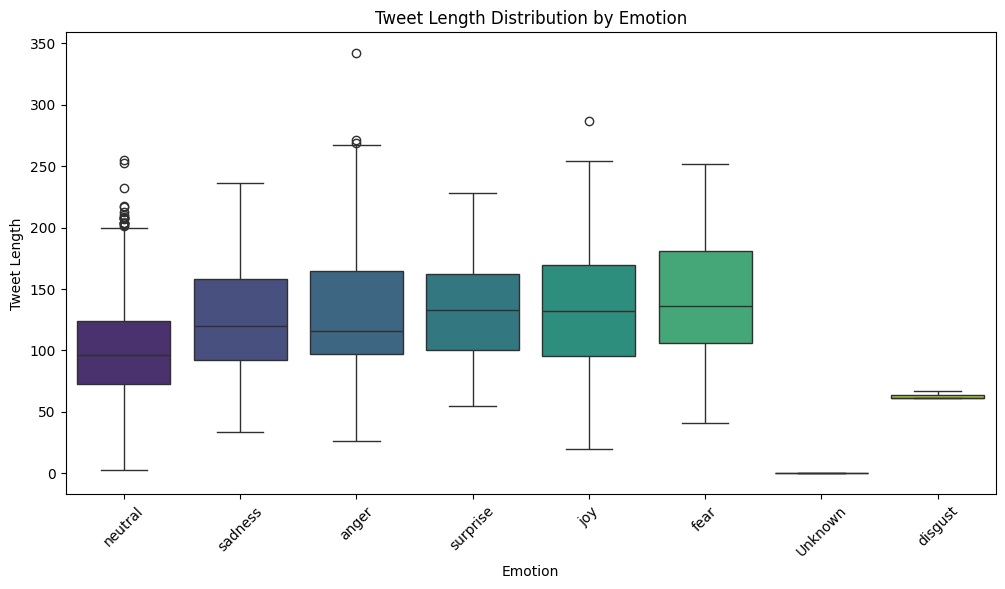

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Phase2_Emotion_Analysis.csv')

def get_tweet_length(text):
    if isinstance(text, str) and text.strip():
        return len(text)
    else:
        return 0

df['Tweet_Length'] = df['Cleaned_Text'].apply(get_tweet_length)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Emotion', y='Tweet_Length', data=df, palette='viridis')
plt.title('Tweet Length Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Tweet Length')
plt.xticks(rotation=45)
plt.show()


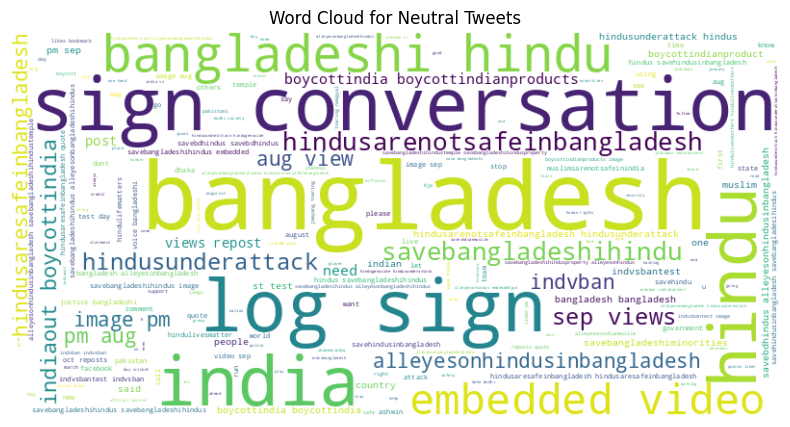

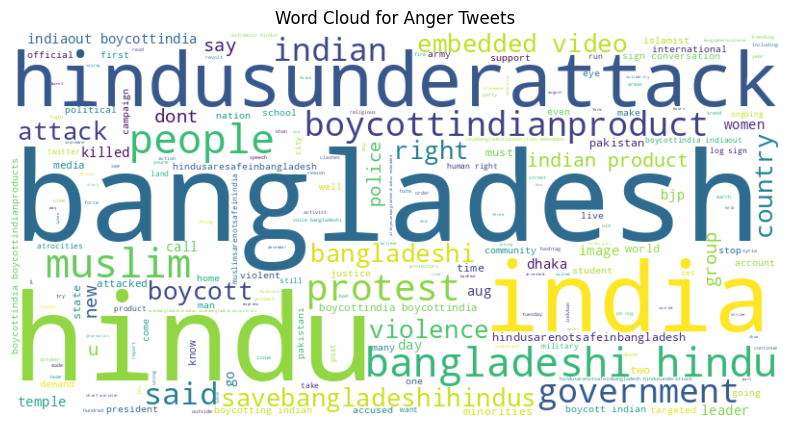

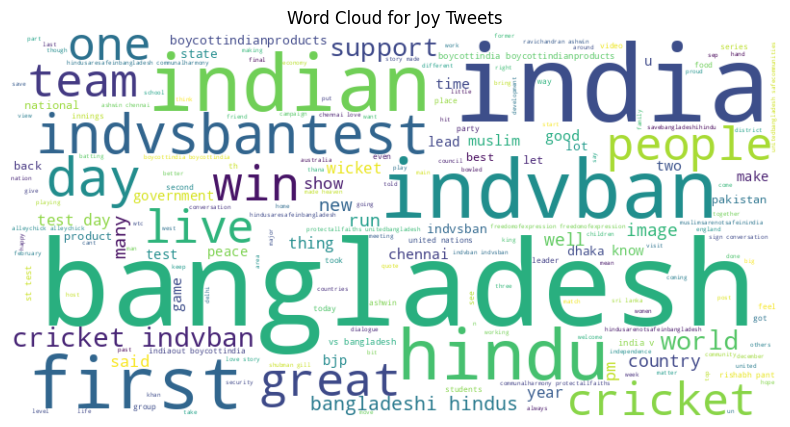

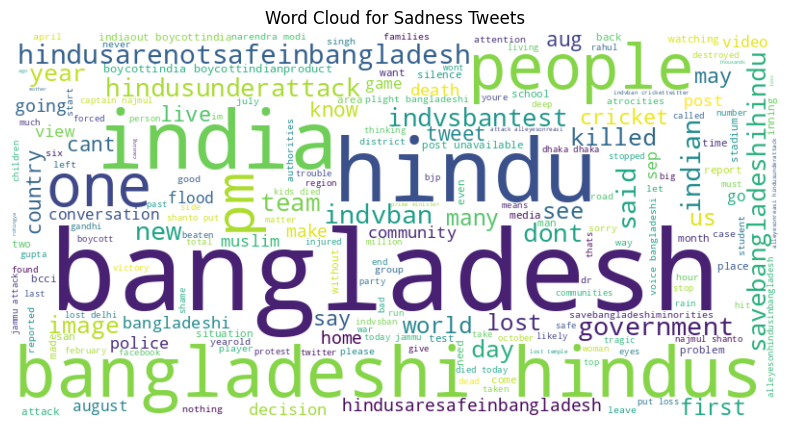

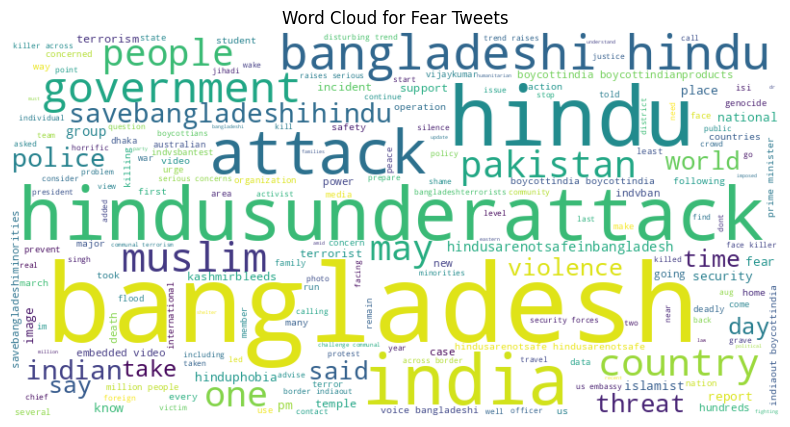

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud_for_emotion(emotion):
    text = ' '.join(df[df['Emotion'] == emotion]['Cleaned_Text'].dropna())
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {emotion.capitalize()} Tweets')
        plt.axis('off')
        plt.show()
    else:
        print(f"No valid text found for {emotion.capitalize()}.")

for emotion in df['Emotion'].value_counts().index[:5]:
    plot_wordcloud_for_emotion(emotion)


Sentiment and Emotion Comparison of During Protest and After Protest

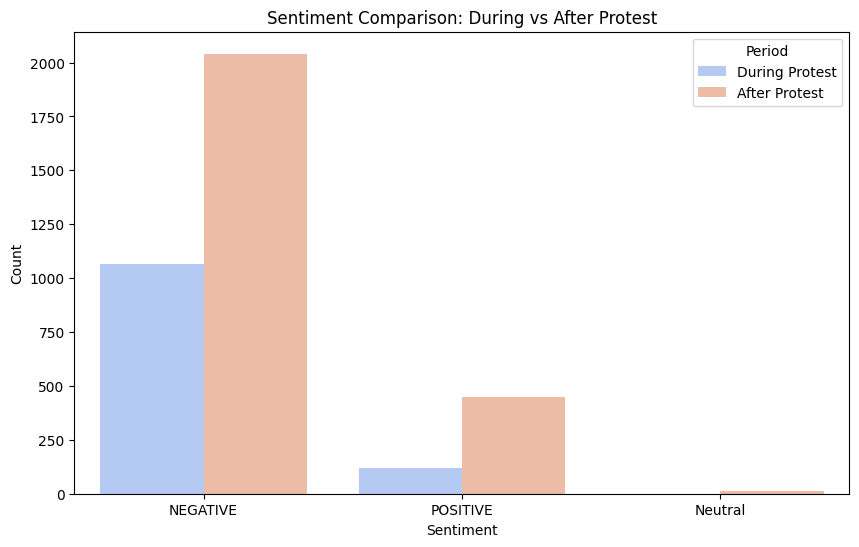

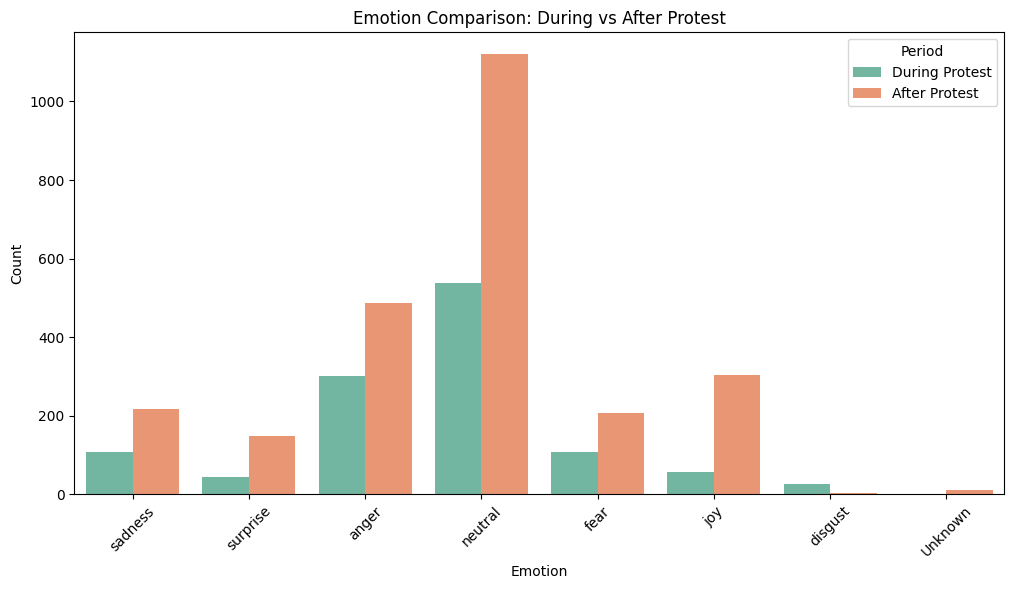

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

during_protest = pd.read_csv('TwitterBD_Protest_Emotion_Analysis.csv')
after_protest = pd.read_csv('Phase2_Emotion_Analysis.csv')

during_protest['Period'] = 'During Protest'
after_protest['Period'] = 'After Protest'

combined_df = pd.concat([during_protest[['Sentiment', 'Emotion', 'Period']], after_protest[['Sentiment', 'Emotion', 'Period']]])

plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', hue='Period', data=combined_df, palette='coolwarm')
plt.title('Sentiment Comparison: During vs After Protest')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Period')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Emotion', hue='Period', data=combined_df, palette='Set2')
plt.title('Emotion Comparison: During vs After Protest')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.show()


Sentiment and Emotion Comparison of During Protest and After Protest (Percentage)

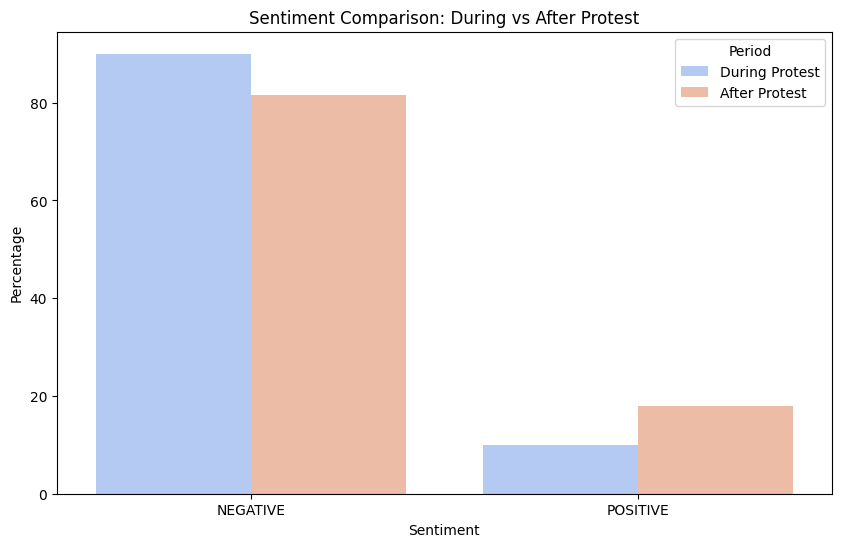

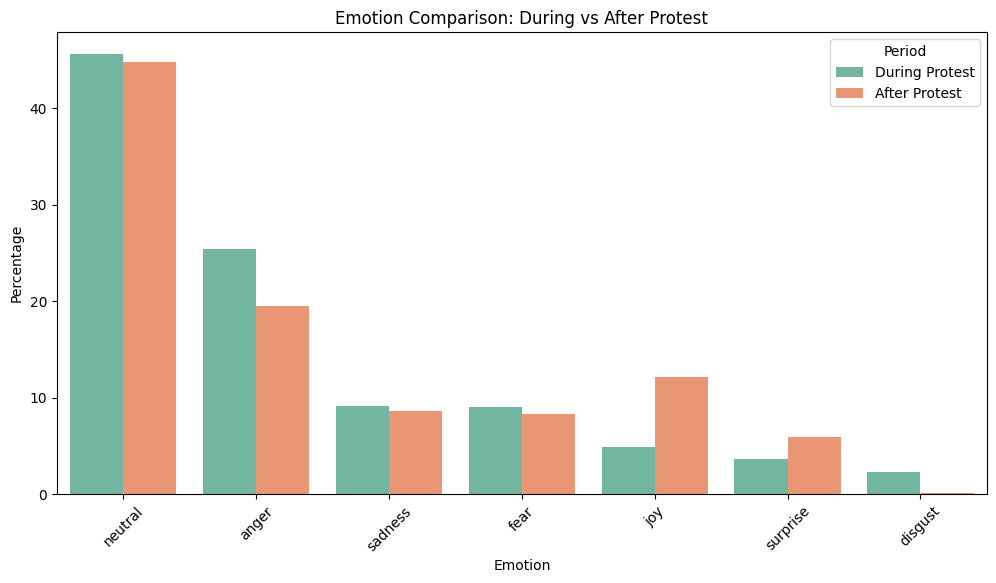

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

during_protest = pd.read_csv('TwitterBD_Protest_Emotion_Analysis.csv')
after_protest = pd.read_csv('Phase2_Emotion_Analysis.csv')

during_protest['Period'] = 'During Protest'
after_protest['Period'] = 'After Protest'

combined_df = pd.concat([during_protest[['Sentiment', 'Emotion', 'Period']],
                         after_protest[['Sentiment', 'Emotion', 'Period']]])

during_sentiment = combined_df[combined_df['Period'] == 'During Protest']['Sentiment'].value_counts(normalize=True) * 100
after_sentiment = combined_df[combined_df['Period'] == 'After Protest']['Sentiment'].value_counts(normalize=True) * 100
sentiment_percentage = pd.DataFrame({'Sentiment': during_sentiment.index,
                                     'During Protest': during_sentiment.values,
                                     'After Protest': after_sentiment.reindex(during_sentiment.index).values})

sentiment_percentage = sentiment_percentage.melt(id_vars='Sentiment', var_name='Period', value_name='Percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Percentage', hue='Period', data=sentiment_percentage, palette='coolwarm')
plt.title('Sentiment Comparison: During vs After Protest')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.legend(title='Period')
plt.show()

during_emotion = combined_df[combined_df['Period'] == 'During Protest']['Emotion'].value_counts(normalize=True) * 100
after_emotion = combined_df[combined_df['Period'] == 'After Protest']['Emotion'].value_counts(normalize=True) * 100
emotion_percentage = pd.DataFrame({'Emotion': during_emotion.index,
                                   'During Protest': during_emotion.values,
                                   'After Protest': after_emotion.reindex(during_emotion.index).values})

emotion_percentage = emotion_percentage.melt(id_vars='Emotion', var_name='Period', value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.barplot(x='Emotion', y='Percentage', hue='Period', data=emotion_percentage, palette='Set2')
plt.title('Emotion Comparison: During vs After Protest')
plt.xlabel('Emotion')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.show()
